# Arguments for benchmarking

In [3]:
import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time
from tqdm import tqdm
import itertools
import shutil
import math
import subprocess
from collections import deque
import multiprocessing
import logging
from enum import Enum


pymeos_initialize()

SRID = 4326
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "PyMEOS_demo"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "trajectory"
x_min = -180
y_min = -90
x_max = 180
y_max = 90
extent_list = [x_min, y_min, x_max, y_max]

class Time_granularity(Enum):
    # MILLISECOND = {"timedelta" : timedelta(milliseconds=1), "qgs_unit" : QgsUnitTypes.TemporalUnit.Milliseconds, "name" : "MILLISECOND"}
    SECOND = {"timedelta" : timedelta(seconds=1), "name" : "SECOND", "steps" : 1}
    MINUTE = {"timedelta" : timedelta(minutes=1), "name" : "MINUTE", "steps" : 1}
    # HOUR = {"timedelta" : timedelta(hours=1), "qgs_unit" : QgsUnitTypes.TemporalUnit.Hours, "name" : "HOUR"}

    @classmethod
    def set_time_step(cls, steps):
        Time_granularity.SECOND.value["timedelta"] = timedelta(seconds=steps)
        Time_granularity.SECOND.value["steps"] = steps
        Time_granularity.MINUTE.value["timedelta"] = timedelta(minutes=steps)
        Time_granularity.MINUTE.value["steps"] = steps
        return cls
    
GRANULARITY = Time_granularity.set_time_step(1).MINUTE

connection_params = {
        "host": "localhost",
        "port": 5432,
        "dbname": DATABASE_NAME,
        "user": "postgres",
        "password": "postgres"
        }
                
connection = MobilityDB.connect(**connection_params)
cursor = connection.cursor()

cursor.execute(f"SELECT {TPOINT_ID_COLUMN_NAME} FROM public.{TPOINT_TABLE_NAME};")
Total_ids = cursor.fetchall()

cursor.execute(f"SELECT MIN(startTimestamp({TPOINT_COLUMN_NAME})) AS earliest_timestamp FROM public.{TPOINT_TABLE_NAME};")
start_date = cursor.fetchone()[0]
cursor.execute(f"SELECT MAX(endTimestamp({TPOINT_COLUMN_NAME})) AS latest_timestamp FROM public.{TPOINT_TABLE_NAME};")
end_date = cursor.fetchone()[0]

total_frames = math.ceil( (end_date - start_date) // GRANULARITY.value["timedelta"] ) + 1

timestamps = [start_date + i * GRANULARITY.value["timedelta"] for i in range(total_frames)]
timestamps = [dt.replace(tzinfo=None) for dt in timestamps]
timestamps_strings = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in timestamps]

begin_frame = 0
end_frame = 239
TIME_DELTA_SIZE = end_frame - begin_frame + 1

ids_list = Total_ids[:int(len(Total_ids)*1)]
ids_list_str = [ f"'{id[0]}'"  for id in ids_list]
objects_id_str = ', '.join(map(str, ids_list_str))

objects_id_str
TIME_DELTA_SIZE

240

# Benchmarking Matrix generation script

Important remarks :

- Approximation results as the load of the active ui animation is hard to simulate aside the matrix calculation. Currently a large animation with 0.5 boat is run beside this script

- Number of time deltas per combination is chosen arbitrarily, 10 in this case, for the sake of simplicity, it is totally possible for a data to be more heavy on a specific time range that may not be covered in the selected deltas

In [5]:


"""
Iterate over all the possible combinations of frames and percentages

for each combination :
    
    Create 3 time deltas
    store : time for each time delta
    store : maximum time for each time delta
    store : average time for each time delta
    
    Calculate FPS using : Frames / maximum time for each time delta

    Store the FPS for each combination

    store the memory used by all 3 time delta in local disk


"""
import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB
from pympler import asizeof
from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time
from tqdm import tqdm
import itertools
import shutil
import math
import subprocess
from collections import deque
import multiprocessing
import logging
from enum import Enum



def create_matrix1(result_queue, begin_frame, end_frame, TIME_DELTA_SIZE, extent, timestamps, connection_params, table_name, id_column_name, tpoint_column_name, GRANULARITY, ids_str):
    """
    This functions runs in a parallel process to fetch the data from the MobilityDB database for the given time delta.
    It creates the numpy matrix and fills it with the positions of the objects for the given time delta.

    """

    p_start = timestamps[begin_frame]
    p_end = timestamps[end_frame]
    start_date = timestamps[0]
    x_min,y_min, x_max, y_max = extent
    logs = ""
    
    # Part 1 : Fetch Tpoints from MobilityDB database
    connection = MobilityDB.connect(**connection_params)    
    cursor = connection.cursor()

    if GRANULARITY.value["name"] == "SECOND": # TODO : handle granularity of different time steps(5 seconds etc)
        time_value = 1 * GRANULARITY.value["steps"]
    elif GRANULARITY.value["name"] == "MINUTE":
        time_value = 60 * GRANULARITY.value["steps"]

    query = f"""WITH trajectories as (
            SELECT 
                atStbox(
                    a.{tpoint_column_name}::tgeompoint,
                    stbox(
                        ST_MakeEnvelope(
                            {x_min}, {y_min}, -- xmin, ymin
                            {x_max}, {y_max}, -- xmax, ymax
                            4326 -- SRID
                        ),
                        tstzspan('[{p_start}, {p_end}]')
                    )
                ) as trajectory
            FROM public.{table_name} as a 
            WHERE a.{id_column_name} in ({ids_str})),

            resampled as (

            SELECT tsample(traj.trajectory, INTERVAL '{GRANULARITY.value["steps"]} {GRANULARITY.value["name"]}', TIMESTAMP '{start_date}')  AS resampled_trajectory
                FROM 
                    trajectories as traj)
        
            SELECT
                    EXTRACT(EPOCH FROM (startTimestamp(rs.resampled_trajectory) - '{start_date}'::timestamp))::integer / {time_value} AS start_index ,
                    EXTRACT(EPOCH FROM (endTimestamp(rs.resampled_trajectory) - '{start_date}'::timestamp))::integer / {time_value} AS end_index,
                    rs.resampled_trajectory
            FROM resampled as rs ;"""

    cursor.execute(query)
    logs += f"query : {query}\n"
    rows = cursor.fetchall()
    cursor.close()
    connection.close()

    # Part 2 : Creating and filling the numpy matrix

    logs += f"Number of rows : {len(rows)}\n"
    empty_point_wkt = Point().wkt  # "POINT EMPTY"
    matrix = np.full((len(rows), TIME_DELTA_SIZE), empty_point_wkt, dtype=object)
    
    for i in range(len(rows)):
        if rows[i][2] is not None:
            try:
                traj_resampled = rows[i][2]

                start_index = rows[i][0] - begin_frame
                end_index = rows[i][1] - begin_frame
                values = np.array([point.wkt for point in traj_resampled.values()])
                matrix[i, start_index:end_index+1] = values
        
            except:
                continue

    logs += f"Matrix shape : {matrix.shape}\n"
    logs += f"Number of non empty points : {np.count_nonzero(matrix != 'POINT EMPTY')}\n"

        
    result_queue.put(matrix)
    result_queue.put(logs)


pymeos_initialize()

SRID = 4326
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "PyMEOS_demo"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "trajectory"
x_min = -180
y_min = -90
x_max = 180
y_max = 90
extent_list = [x_min, y_min, x_max, y_max]

class Time_granularity(Enum):
    # MILLISECOND = {"timedelta" : timedelta(milliseconds=1), "qgs_unit" : QgsUnitTypes.TemporalUnit.Milliseconds, "name" : "MILLISECOND"}
    SECOND = {"timedelta" : timedelta(seconds=1), "name" : "SECOND", "steps" : 1}
    MINUTE = {"timedelta" : timedelta(minutes=1), "name" : "MINUTE", "steps" : 1}
    # HOUR = {"timedelta" : timedelta(hours=1), "qgs_unit" : QgsUnitTypes.TemporalUnit.Hours, "name" : "HOUR"}

    @classmethod
    def set_time_step(cls, steps):
        Time_granularity.SECOND.value["timedelta"] = timedelta(seconds=steps)
        Time_granularity.SECOND.value["steps"] = steps
        Time_granularity.MINUTE.value["timedelta"] = timedelta(minutes=steps)
        Time_granularity.MINUTE.value["steps"] = steps
        return cls
    
GRANULARITY = Time_granularity.set_time_step(1).MINUTE

connection_params = {
        "host": "localhost",
        "port": 5432,
        "dbname": DATABASE_NAME,
        "user": "postgres",
        "password": "postgres"
        }
                
connection = MobilityDB.connect(**connection_params)
cursor = connection.cursor()

cursor.execute(f"SELECT {TPOINT_ID_COLUMN_NAME} FROM public.{TPOINT_TABLE_NAME};")
Total_ids = cursor.fetchall()

cursor.execute(f"SELECT MIN(startTimestamp({TPOINT_COLUMN_NAME})) AS earliest_timestamp FROM public.{TPOINT_TABLE_NAME};")
start_date = cursor.fetchone()[0]
cursor.execute(f"SELECT MAX(endTimestamp({TPOINT_COLUMN_NAME})) AS latest_timestamp FROM public.{TPOINT_TABLE_NAME};")
end_date = cursor.fetchone()[0]

total_frames = math.ceil( (end_date - start_date) // GRANULARITY.value["timedelta"] ) + 1

timestamps = [start_date + i * GRANULARITY.value["timedelta"] for i in range(total_frames)]
timestamps = [dt.replace(tzinfo=None) for dt in timestamps]
timestamps_strings = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in timestamps]


TIME_DELTA_COUNT = 10


Frames = [10, 60, 120, 240, 480]
Percentages = [0.1, 0.25, 0.5, 0.75, 1]

number_of_objects={} # Store the number of objects for each percentage
times = {} # Store the time for each time delta
memory_used = {} # Store the memory used for each combination

combinations = tqdm(list(itertools.product(Frames, Percentages)))

for combination in combinations:
    combinations.set_description(f"Combination {combination}")
    frame, percentage = combination

    
    ids_list = Total_ids[:int(len(Total_ids)*percentage)]

    ids_list_str = [ f"'{id[0]}'"  for id in ids_list]
    objects_id_str = ', '.join(map(str, ids_list_str))
    number_of_objects[percentage] = len(ids_list)


    # print(combination)

   
    t_deltas = tqdm([(i, (i+frame)-1) for i in range(0, 3*frame, frame)]) 
    # print(t_deltas)
    times[combination] = []
    memory_used[combination] = 0
    for delta in t_deltas:
        t_deltas.set_description(f"Time delta {delta}")
        now = time.time()
        x_min,y_min, x_max, y_max = extent_list
        begin_frame, end_frame = delta


        result_queue = multiprocessing.Queue()

        # log(f"arguments : begin_frame : {self.begin_frame}, end_frame : {self.end_frame}, TIME_DELTA_SIZE : {TIME_DELTA_SIZE}, PERCENTAGE_OF_OBJECTS : {PERCENTAGE_OF_OBJECTS}, {self.extent}, len timestamps :{len(self.timestamps)}, granularity : {GRANULARITY.value},{len(self.objects_id_str)}")
        process = multiprocessing.Process(target=create_matrix1, args=(result_queue, begin_frame, end_frame, frame, extent_list, timestamps, connection_params, TPOINT_TABLE_NAME, TPOINT_ID_COLUMN_NAME, TPOINT_COLUMN_NAME, GRANULARITY, objects_id_str))
        process.start()
        # log(f"Process started")


        # Retrieve the result from the queue
        result_matrix = result_queue.get()
        logs= result_queue.get()
        result_queue.close()
        process.join()  # Wait for the process to complete

        
        TIME_total = time.time() - now
        times[combination].append(TIME_total)

        size_in_bytes = asizeof.asizeof(result_matrix)
        size_in_megabytes = size_in_bytes / (1024 * 1024)
        memory_used[combination] += size_in_megabytes
    
    
    



Combination (10, 0.5):   8%|▊         | 2/25 [00:12<02:21,  6.15s/it]


KeyboardInterrupt: 

In [13]:
number_of_objects

{0.1: 582, 0.5: 2910, 1: 5821}

In [14]:
memory_used

{(10, 0.1): 0.4168701171875,
 (10, 0.5): 2.180704116821289,
 (10, 1): 4.510184288024902,
 (60, 0.1): 2.7187366485595703,
 (60, 0.5): 14.488865852355957,
 (60, 1): 29.763100624084473,
 (120, 0.1): 5.5711469650268555,
 (120, 0.5): 29.599886894226074,
 (120, 1): 60.662577629089355,
 (240, 0.1): 11.762939453125,
 (240, 0.5): 61.61973571777344,
 (240, 1): 125.95961856842041,
 (480, 0.1): 24.75767421722412,
 (480, 0.5): 127.56088638305664,
 (480, 1): 260.59914207458496,
 (960, 0.1): 50.78852653503418,
 (960, 0.5): 261.52373027801514,
 (960, 1): 532.4159679412842}

# Average time to generate T delta per combination

In [16]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.0 MB/s eta 0:00:00a 0:00:01


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

avg_data = {key: np.mean(value) for key, value in times.items()}
avg_data

df = pd.DataFrame.from_dict(avg_data, orient='index', columns=['Average'])
df.index = pd.MultiIndex.from_tuples(df.index, names=['Frames', 'Percentage'])

df

Average
Frames Percentage           
10     0.1          0.267903
       0.5          0.486584
       1.0          0.854849
60     0.1          0.373073
       0.5          1.182086
       1.0          2.283915
120    0.1          0.511666
       0.5          2.061354
       1.0          3.985176
240    0.1          0.808131
       0.5          3.804998
       1.0          7.618107
480    0.1          1.430111
       0.5          7.533343
       1.0         15.217157
960    0.1          2.744219
       0.5         15.248791
       1.0         31.119190

In [18]:
df_unstacked = df.unstack(level=-1) 
df_unstacked

Average                      
Percentage       0.1        0.5        1.0
Frames                                    
10          0.267903   0.486584   0.854849
60          0.373073   1.182086   2.283915
120         0.511666   2.061354   3.985176
240         0.808131   3.804998   7.618107
480         1.430111   7.533343  15.217157
960         2.744219  15.248791  31.119190

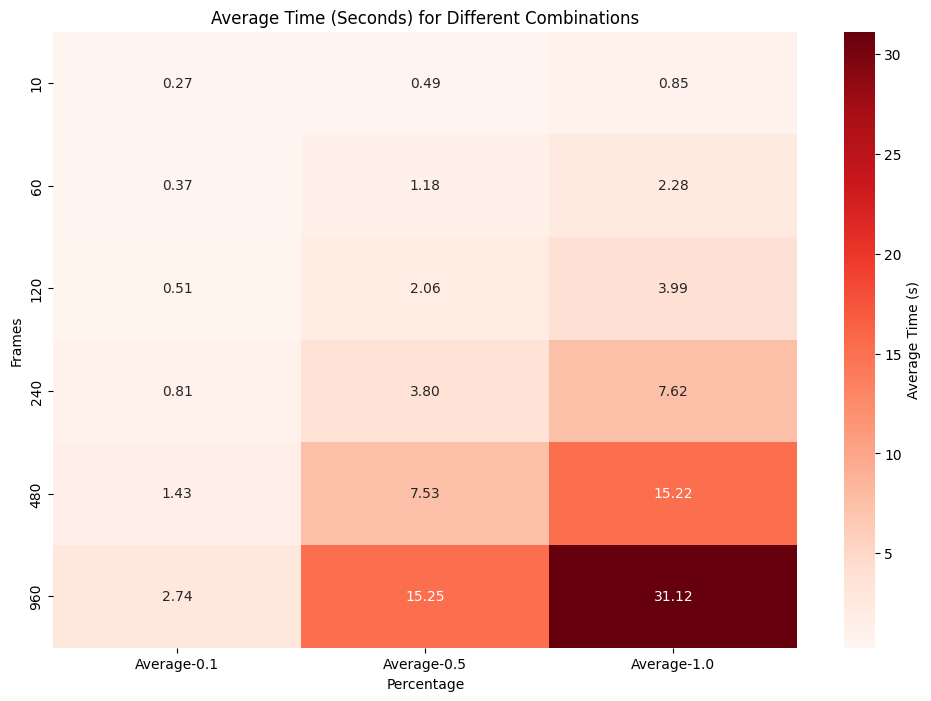

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_unstacked, annot=True, cmap='Reds', fmt=".2f", cbar_kws={'label': 'Average Time (s)'})
plt.title('Average Time (Seconds) for Different Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()

# MAX FPS for uninterrupted animation per combinations

The formula used to get the max FPS, with uninterrupted animation :

$$
Max FPS = \frac{| frames |}{\max(\text{time to generate next matrix})}
$$


In [20]:
max_data = {key: max(value) for key, value in times.items()}

# Calculate the FPS values using the maximum values
fps_values = {key: key[0] / value for key, value in max_data.items()}
fps_values

{(10, 0.1): 33.248255465073235,
 (10, 0.5): 17.856384450660094,
 (10, 1): 10.36618091999737,
 (60, 0.1): 137.14352977849035,
 (60, 0.5): 45.34114740606321,
 (60, 1): 23.923891717917794,
 (120, 0.1): 210.42459391222658,
 (120, 0.5): 53.179910844944374,
 (120, 1): 27.575028000091383,
 (240, 0.1): 266.07807520781216,
 (240, 0.5): 57.955046066304824,
 (240, 1): 29.344914740305278,
 (480, 0.1): 310.8148061693453,
 (480, 0.5): 57.58589755760782,
 (480, 1): 29.664206198676045,
 (960, 0.1): 317.7535628127498,
 (960, 0.5): 58.10203976589616,
 (960, 1): 28.614874227305013}

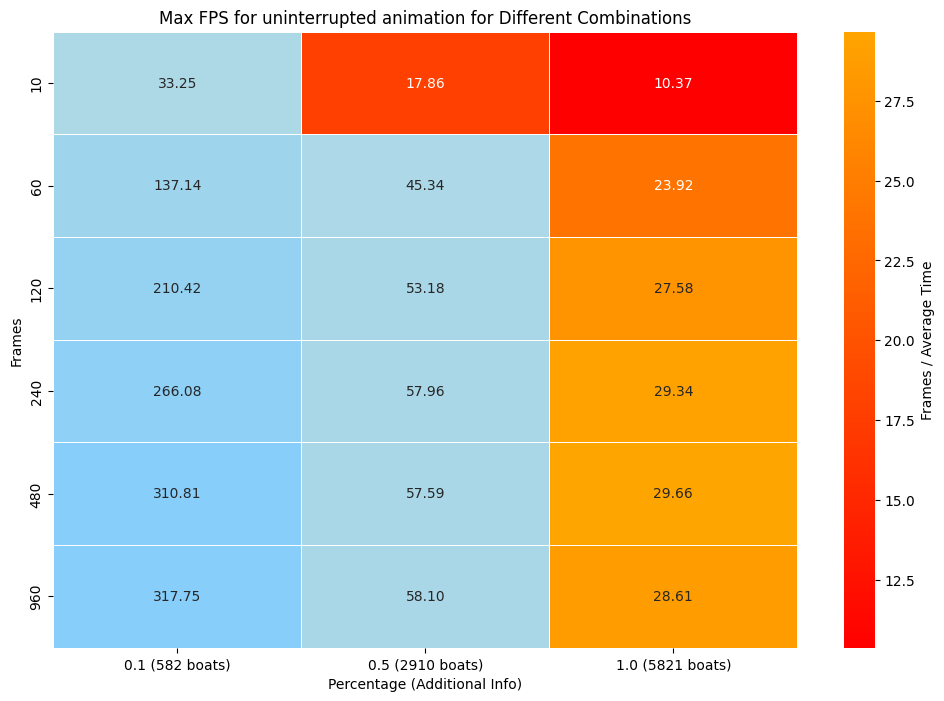

In [22]:
# fps_values = {key: key[0] / value for key, value in avg_data.items()}


df_frames_per_value = pd.DataFrame.from_dict(fps_values, orient='index', columns=['Frames_per_Value'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]

# for values below 30
colors_below_30 = ["red", "orange"]
cmap_below_30 = LinearSegmentedColormap.from_list("Below30Colormap", colors_below_30)

# above 30
colors_above_30 = ["#ADD8E6", "#87CEFA"]
cmap_above_30 = LinearSegmentedColormap.from_list("Above30Colormap", colors_above_30)

# Create a mask for values below and above 30
mask_below_30 = df_frames_per_value_unstacked >= 30
mask_above_30 = df_frames_per_value_unstacked < 30

# Plot the heatmap with inverted color gradient for values below 30
plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_below_30, fmt=".2f", cbar_kws={'label': 'Frames / Average Time'}, mask=mask_below_30, linewidths=.5)
light_blue = "#add8e6"  # 
cmap_single_shade = mcolors.ListedColormap([light_blue]) 
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_above_30, fmt=".2f", cbar=False, mask=mask_above_30, linewidths=.5)
plt.title('Max FPS for uninterrupted animation for Different Combinations')
plt.xlabel('Percentage (Additional Info)')
plt.ylabel('Frames')
plt.show()

# Memory occupied on disk by 3 matrices (t-1, t, t+1)

In [23]:
memory_used

{(10, 0.1): 0.4168701171875,
 (10, 0.5): 2.180704116821289,
 (10, 1): 4.510184288024902,
 (60, 0.1): 2.7187366485595703,
 (60, 0.5): 14.488865852355957,
 (60, 1): 29.763100624084473,
 (120, 0.1): 5.5711469650268555,
 (120, 0.5): 29.599886894226074,
 (120, 1): 60.662577629089355,
 (240, 0.1): 11.762939453125,
 (240, 0.5): 61.61973571777344,
 (240, 1): 125.95961856842041,
 (480, 0.1): 24.75767421722412,
 (480, 0.5): 127.56088638305664,
 (480, 1): 260.59914207458496,
 (960, 0.1): 50.78852653503418,
 (960, 0.5): 261.52373027801514,
 (960, 1): 532.4159679412842}

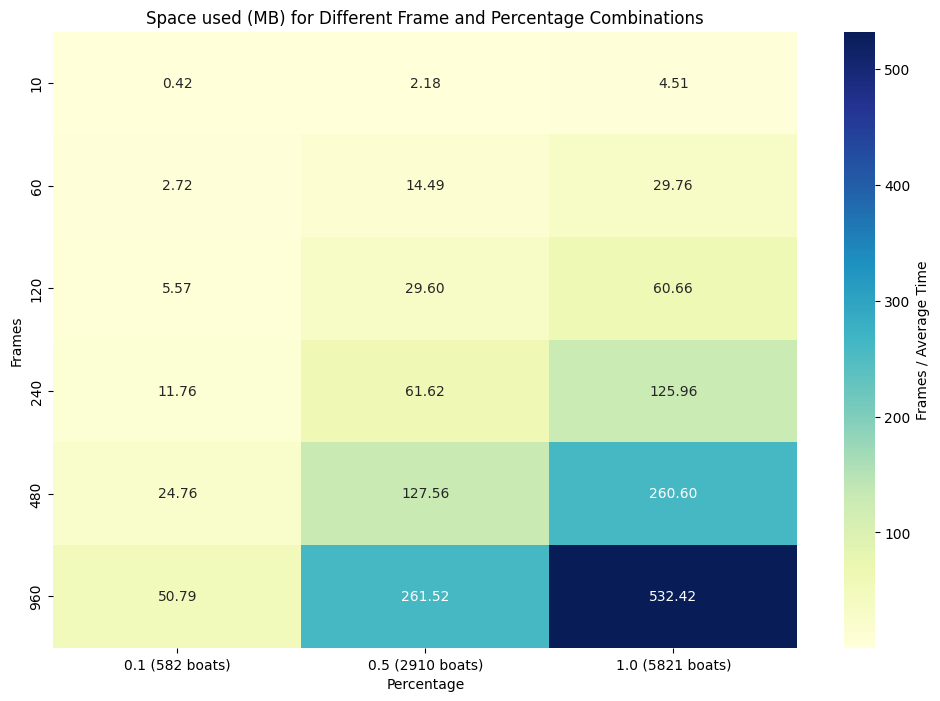

In [24]:


df_frames_per_value = pd.DataFrame.from_dict(memory_used, orient='index', columns=['%'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]


plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Frames / Average Time'})
plt.title('Space used (MB) for Different Frame and Percentage Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()

# Moving resampling and indexing to database

In [1]:

import numpy as np
from shapely.geometry import Point
from pymeos.db.psycopg import MobilityDB

from pymeos import *
import os
import sys
from datetime import timedelta, datetime
from pymeos import *
import time
from tqdm import tqdm
import itertools
import shutil
import math
import subprocess
from collections import deque

def get_folder_size_mb(dir_name):
    total_size = 0
    sizes = deque(maxlen=3)
    for dirpath, dirnames, filenames in os.walk(dir_name):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            # Skip if it is symbolic link
            if not os.path.islink(file_path):
                sizes.append(os.path.getsize(file_path))
    # Convert size to MB
    total_size_mb = sum(sizes) / (1024 * 1024)
    return total_size_mb

"""
Iterate over all the possible combinations of frames and percentages

for each combination :
    
    Create 3 time deltas
    store : time for each time delta
    store : maximum time for each time delta
    store : average time for each time delta
    
    Calculate FPS using : Frames / maximum time for each time delta

    Store the FPS for each combination

    store the memory used by all 3 time delta in local disk


"""


MATRIX_DIRECTORY_PATH ="/home/ali/matrices/" 
if os.path.exists(MATRIX_DIRECTORY_PATH):
    shutil.rmtree(MATRIX_DIRECTORY_PATH)
    os.makedirs(MATRIX_DIRECTORY_PATH)
else:
    os.makedirs(MATRIX_DIRECTORY_PATH)
pymeos_initialize()

SRID = 4326
DATABASE_NAME = "mobilitydb"
TPOINT_TABLE_NAME = "PyMEOS_demo"
TPOINT_ID_COLUMN_NAME = "MMSI"
TPOINT_COLUMN_NAME = "trajectory"
x_min = -180
y_min = -90
x_max = 180
y_max = 90
extent_list = [x_min, y_min, x_max, y_max]
Time_granularities = {
                    # "MILLISECOND" : timedelta(milliseconds=1),
                      "SECOND" : timedelta(seconds=1),
                      "MINUTE" : timedelta(minutes=1),
                    #   "HOUR" : timedelta(hours=1),
                    }
GRANULARITY = Time_granularities["SECOND"]

connection_params = {
        "host": "localhost",
        "port": 5432,
        "dbname": DATABASE_NAME,
        "user": "postgres",
        "password": "postgres"
        }
                
connection = MobilityDB.connect(**connection_params)
cursor = connection.cursor()

cursor.execute(f"SELECT {TPOINT_ID_COLUMN_NAME} FROM public.{TPOINT_TABLE_NAME};")
Total_ids = cursor.fetchall()

cursor.execute(f"SELECT MIN(startTimestamp({TPOINT_COLUMN_NAME})) AS earliest_timestamp FROM public.{TPOINT_TABLE_NAME};")
start_date = cursor.fetchone()[0]
cursor.execute(f"SELECT MAX(endTimestamp({TPOINT_COLUMN_NAME})) AS latest_timestamp FROM public.{TPOINT_TABLE_NAME};")
end_date = cursor.fetchone()[0]

total_frames = math.ceil( (end_date - start_date) // GRANULARITY ) + 1

timestamps = [start_date + i * GRANULARITY for i in range(total_frames)]
timestamps = [dt.replace(tzinfo=None) for dt in timestamps]
timestamps_strings = [dt.strftime('%Y-%m-%d %H:%M:%S') for dt in timestamps]


TIME_DELTA_COUNT = 10


Frames = [10, 60, 120, 240, 480, 960]
Percentages = [0.1, 0.5,  1]

number_of_objects={} # Store the number of objects for each percentage
times = {} # Store the time for each time delta
memory_used = {} # Store the memory used for each combination

combinations = tqdm(list(itertools.product(Frames, Percentages)))

for combination in combinations:
    combinations.set_description(f"Combination {combination}")
    frame, percentage = combination

    
    ids_list = Total_ids[:int(len(Total_ids)*percentage)]
    number_of_objects[percentage] = len(ids_list)


    # print(combination)
    dir_name = f"/home/ali/matrices/{frame}_{percentage}"
    # print(dir_name)
    os.mkdir(dir_name)
   
    t_deltas = tqdm([(i, (i+frame)-1) for i in range(0, 10*frame, frame)]) 
    # print(t_deltas)
    times[combination] = []
    for delta in t_deltas:
        t_deltas.set_description(f"Time delta {delta}")
        now = time.time()
        x_min,y_min, x_max, y_max = extent_list
        begin_frame, end_frame = delta
        arguments = [begin_frame, end_frame, percentage, x_min, y_min, x_max, y_max]
        arguments = [str(arg) for arg in arguments]
        arguments += [timestamps_strings[begin_frame],  str(len(timestamps)),
                'SECOND',
                dir_name,
                'mobilitydb',
                'pymeos_demo',
                'MMSI',
                'trajectory']
     

        python_path = sys.executable
        process_B_path = f"/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py"
        
        command = [python_path, process_B_path, *arguments]
        result = subprocess.run(command, capture_output=True, text=True)
        print(result)
        
        loaded_matrix = np.load(f"{dir_name}/matrix_{begin_frame}.npy", allow_pickle=True)

        TIME_total = time.time() - now
        times[combination].append(TIME_total)
    size = get_folder_size_mb(dir_name) 
    memory_used[combination] = size
    shutil.rmtree(dir_name)
        
    
    



Combination (10, 0.1):   0%|          | 0/18 [00:00<?, ?it/s]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '9', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.003880023956298828 seconds, 0.11640071868896484 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '10', '19', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 10 created in 0.007762432098388672 seconds, 0.23287296295166016 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '20', '29', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 20 created in 0.008541107177734375 seconds, 0.25623321533203125 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '30', '39', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 30 created in 0.00936269760131836 seconds, 0.2808809280395508 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '40', '49', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 40 created in 0.010020971298217773 seconds, 0.3006291389465332 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '50', '59', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 50 created in 0.011120080947875977 seconds, 0.3336024284362793 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '60', '69', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.011363506317138672 seconds, 0.34090518951416016 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '70', '79', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 70 created in 0.013041496276855469 seconds, 0.39124488830566406 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '80', '89', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 80 created in 0.013085365295410156 seconds, 0.3925609588623047 frames for 30 fps animation.\n', stderr='')


Combination (10, 0.5):   6%|▌         | 1/18 [00:03<00:51,  3.05s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '90', '99', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 90 created in 0.013743877410888672 seconds, 0.41231632232666016 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '9', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.03222084045410156 seconds, 0.9666252136230469 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '10', '19', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 10 created in 0.055233001708984375 seconds, 1.6569900512695312 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '20', '29', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 20 created in 0.05757021903991699 seconds, 1.7271065711975098 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '30', '39', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 30 created in 0.06394600868225098 seconds, 1.9183802604675293 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '40', '49', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 40 created in 0.0684664249420166 seconds, 2.053992748260498 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '50', '59', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 50 created in 0.07746362686157227 seconds, 2.323908805847168 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '60', '69', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.08963322639465332 seconds, 2.6889967918395996 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '70', '79', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 70 created in 0.10040473937988281 seconds, 3.0121421813964844 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '80', '89', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 80 created in 0.09939193725585938 seconds, 2.9817581176757812 frames for 30 fps animation.\n', stderr='')


Combination (10, 1):  11%|█         | 2/18 [00:08<01:14,  4.68s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '90', '99', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 90 created in 0.10683369636535645 seconds, 3.2050108909606934 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '9', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.05206012725830078 seconds, 1.5618038177490234 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '10', '19', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:10', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 10 created in 0.11202096939086914 seconds, 3.360629081726074 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '20', '29', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:20', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 20 created in 0.1301102638244629 seconds, 3.9033079147338867 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '30', '39', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:30', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 30 created in 0.13942861557006836 seconds, 4.182858467102051 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '40', '49', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:40', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 40 created in 0.15160250663757324 seconds, 4.548075199127197 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '50', '59', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:50', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 50 created in 0.16387248039245605 seconds, 4.916174411773682 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '60', '69', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.17046713829040527 seconds, 5.114014148712158 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '70', '79', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:10', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 70 created in 0.1968686580657959 seconds, 5.906059741973877 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '80', '89', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:20', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 80 created in 0.19304800033569336 seconds, 5.791440010070801 frames for 30 fps animation.\n', stderr='')


Combination (60, 0.1):  17%|█▋        | 3/18 [00:20<01:55,  7.70s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '90', '99', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:30', '86399', 'SECOND', '/home/ali/matrices/10_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 90 created in 0.2099449634552002 seconds, 6.298348903656006 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '59', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.038776397705078125 seconds, 1.1632919311523438 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '60', '119', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.07662320137023926 seconds, 2.2986960411071777 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '120', '179', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 0.08529257774353027 seconds, 2.558777332305908 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '180', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 180 created in 0.08939743041992188 seconds, 2.6819229125976562 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '299', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 0.09431266784667969 seconds, 2.8293800354003906 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '300', '359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 300 created in 0.12880682945251465 seconds, 3.8642048835754395 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '360', '419', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 0.09935164451599121 seconds, 2.9805493354797363 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '420', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 420 created in 0.10012364387512207 seconds, 3.003709316253662 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '539', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 0.10267019271850586 seconds, 3.080105781555176 frames for 30 fps animation.\n', stderr='')


Combination (60, 0.5):  22%|██▏       | 4/18 [00:24<01:27,  6.24s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '540', '599', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 540 created in 0.10450935363769531 seconds, 3.1352806091308594 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '59', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.2761695384979248 seconds, 8.285086154937744 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '60', '119', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 0.5078732967376709 seconds, 15.236198902130127 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '120', '179', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 0.5928285121917725 seconds, 17.784855365753174 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '180', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 180 created in 0.6614959239959717 seconds, 19.84487771987915 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '299', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 0.638899564743042 seconds, 19.16698694229126 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '300', '359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 300 created in 0.6644504070281982 seconds, 19.933512210845947 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '360', '419', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 0.6859357357025146 seconds, 20.57807207107544 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '420', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 420 created in 0.6812417507171631 seconds, 20.437252521514893 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '539', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 0.6922106742858887 seconds, 20.76632022857666 frames for 30 fps animation.\n', stderr='')


Combination (60, 1):  28%|██▊       | 5/18 [00:36<01:49,  8.42s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '540', '599', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 540 created in 0.7134945392608643 seconds, 21.404836177825928 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '59', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.620476245880127 seconds, 18.61428737640381 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '60', '119', '1', '-180', '-90', '180', '90', '2023-06-01 00:01:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 60 created in 1.122863531112671 seconds, 33.68590593338013 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '120', '179', '1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 1.248230218887329 seconds, 37.44690656661987 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '180', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:03:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 180 created in 1.3131170272827148 seconds, 39.393510818481445 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '299', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 1.3587582111358643 seconds, 40.76274633407593 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '300', '359', '1', '-180', '-90', '180', '90', '2023-06-01 00:05:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 300 created in 1.3425626754760742 seconds, 40.27688026428223 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '360', '419', '1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 1.3818833827972412 seconds, 41.456501483917236 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '420', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:07:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 420 created in 1.436924695968628 seconds, 43.10774087905884 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '539', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 1.4132914543151855 seconds, 42.398743629455566 frames for 30 fps animation.\n', stderr='')


Combination (120, 0.1):  33%|███▎      | 6/18 [01:01<02:47, 13.94s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '540', '599', '1', '-180', '-90', '180', '90', '2023-06-01 00:09:00', '86399', 'SECOND', '/home/ali/matrices/60_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 540 created in 1.3885612487792969 seconds, 41.656837463378906 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '119', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.09206748008728027 seconds, 2.762024402618408 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '120', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 0.17526769638061523 seconds, 5.258030891418457 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 0.18435025215148926 seconds, 5.530507564544678 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '360', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 0.20115041732788086 seconds, 6.034512519836426 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '599', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 0.20160746574401855 seconds, 6.048223972320557 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '600', '719', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 600 created in 0.22259879112243652 seconds, 6.677963733673096 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '720', '839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 0.22374248504638672 seconds, 6.712274551391602 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '840', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 840 created in 0.2281661033630371 seconds, 6.844983100891113 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1079', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 0.21770501136779785 seconds, 6.5311503410339355 frames for 30 fps animation.\n', stderr='')


Combination (120, 0.5):  39%|███▉      | 7/18 [01:06<02:02, 11.10s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1080', '1199', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1080 created in 0.2309436798095703 seconds, 6.928310394287109 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '119', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.663031816482544 seconds, 19.89095449447632 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '120', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 1.2118990421295166 seconds, 36.3569712638855 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 1.300560712814331 seconds, 39.01682138442993 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '360', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 1.3212754726409912 seconds, 39.638264179229736 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '599', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 1.3847718238830566 seconds, 41.5431547164917 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '600', '719', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 600 created in 1.360027551651001 seconds, 40.80082654953003 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '720', '839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 1.4027645587921143 seconds, 42.08293676376343 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '840', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 840 created in 1.434053659439087 seconds, 43.02160978317261 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1079', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 1.4412825107574463 seconds, 43.23847532272339 frames for 30 fps animation.\n', stderr='')


Combination (120, 1):  44%|████▍     | 8/18 [01:26<02:20, 14.08s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1080', '1199', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1080 created in 1.5469775199890137 seconds, 46.40932559967041 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '119', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 1.4356019496917725 seconds, 43.068058490753174 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '120', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:02:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 120 created in 2.4239611625671387 seconds, 72.71883487701416 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '359', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 2.611037492752075 seconds, 78.33112478256226 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '360', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:06:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 360 created in 2.677786350250244 seconds, 80.33359050750732 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '599', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 2.772348165512085 seconds, 83.17044496536255 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '600', '719', '1', '-180', '-90', '180', '90', '2023-06-01 00:10:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 600 created in 2.9033355712890625 seconds, 87.10006713867188 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '720', '839', '1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 2.9182798862457275 seconds, 87.54839658737183 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '840', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:14:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 840 created in 2.8871757984161377 seconds, 86.61527395248413 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1079', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 2.846700668334961 seconds, 85.40102005004883 frames for 30 fps animation.\n', stderr='')


Combination (240, 0.1):  50%|█████     | 9/18 [02:07<03:22, 22.48s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1080', '1199', '1', '-180', '-90', '180', '90', '2023-06-01 00:18:00', '86399', 'SECOND', '/home/ali/matrices/120_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1080 created in 2.9041941165924072 seconds, 87.12582349777222 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '239', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.2601897716522217 seconds, 7.80569314956665 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 0.3843669891357422 seconds, 11.531009674072266 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '719', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 0.4005856513977051 seconds, 12.017569541931152 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '720', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 0.44463133811950684 seconds, 13.338940143585205 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1199', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 0.43703126907348633 seconds, 13.11093807220459 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1200', '1439', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1200 created in 0.46391797065734863 seconds, 13.917539119720459 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1440', '1679', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 0.48146915435791016 seconds, 14.444074630737305 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1680', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1680 created in 0.4855082035064697 seconds, 14.565246105194092 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2159', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 0.4994080066680908 seconds, 14.982240200042725 frames for 30 fps animation.\n', stderr='')


Combination (240, 0.5):  56%|█████▌    | 10/18 [02:15<02:24, 18.05s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2160', '2399', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2160 created in 0.5184569358825684 seconds, 15.55370807647705 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '239', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 1.69980788230896 seconds, 50.9942364692688 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 2.6311557292938232 seconds, 78.9346718788147 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '719', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 2.7579190731048584 seconds, 82.73757219314575 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '720', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 2.8271446228027344 seconds, 84.81433868408203 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1199', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 2.905160903930664 seconds, 87.15482711791992 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1200', '1439', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1200 created in 2.9212450981140137 seconds, 87.63735294342041 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1440', '1679', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 2.8882431983947754 seconds, 86.64729595184326 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1680', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1680 created in 2.9953320026397705 seconds, 89.85996007919312 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2159', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 2.9972169399261475 seconds, 89.91650819778442 frames for 30 fps animation.\n', stderr='')


Combination (240, 1):  61%|██████    | 11/18 [02:53<02:48, 24.09s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2160', '2399', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2160 created in 3.0172083377838135 seconds, 90.5162501335144 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '239', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 3.737859010696411 seconds, 112.13577032089233 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '240', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:04:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 240 created in 5.421264171600342 seconds, 162.63792514801025 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '719', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 5.697500228881836 seconds, 170.92500686645508 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '720', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:12:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 720 created in 5.645489454269409 seconds, 169.36468362808228 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1199', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 5.905031442642212 seconds, 177.15094327926636 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1200', '1439', '1', '-180', '-90', '180', '90', '2023-06-01 00:20:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1200 created in 5.8252785205841064 seconds, 174.7583556175232 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1440', '1679', '1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 5.845347166061401 seconds, 175.36041498184204 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1680', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:28:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1680 created in 5.922778129577637 seconds, 177.6833438873291 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2159', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 6.001558542251587 seconds, 180.0467562675476 frames for 30 fps animation.\n', stderr='')


Combination (480, 0.1):  67%|██████▋   | 12/18 [04:09<03:59, 39.97s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2160', '2399', '1', '-180', '-90', '180', '90', '2023-06-01 00:36:00', '86399', 'SECOND', '/home/ali/matrices/240_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2160 created in 6.0967395305633545 seconds, 182.90218591690063 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '479', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 0.5790195465087891 seconds, 17.370586395263672 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 0.8697175979614258 seconds, 26.091527938842773 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1439', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 0.9666135311126709 seconds, 28.998405933380127 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1440', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 0.9641199111938477 seconds, 28.92359733581543 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2399', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 0.9925885200500488 seconds, 29.777655601501465 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2400', '2879', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2400 created in 1.0068755149841309 seconds, 30.206265449523926 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2880', '3359', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 1.0596301555633545 seconds, 31.788904666900635 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3360', '3839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3360 created in 1.055480718612671 seconds, 31.664421558380127 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3840', '4319', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 1.0478262901306152 seconds, 31.434788703918457 frames for 30 fps animation.\n', stderr='')


Combination (480, 0.5):  72%|███████▏  | 13/18 [04:24<02:41, 32.21s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '4320', '4799', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4320 created in 1.0668425559997559 seconds, 32.005276679992676 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '479', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 4.28305721282959 seconds, 128.4917163848877 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 5.498317718505859 seconds, 164.94953155517578 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1439', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 5.7153027057647705 seconds, 171.45908117294312 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1440', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 6.421889781951904 seconds, 192.65669345855713 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2399', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 6.272632360458374 seconds, 188.17897081375122 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2400', '2879', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2400 created in 6.105738639831543 seconds, 183.1721591949463 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2880', '3359', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 6.218127489089966 seconds, 186.54382467269897 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3360', '3839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3360 created in 6.266677618026733 seconds, 188.000328540802 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3840', '4319', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 6.226605176925659 seconds, 186.79815530776978 frames for 30 fps animation.\n', stderr='')


Combination (480, 1):  78%|███████▊  | 14/18 [05:39<03:00, 45.22s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '4320', '4799', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4320 created in 6.375834941864014 seconds, 191.2750482559204 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '479', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 9.086968898773193 seconds, 272.6090669631958 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '480', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:08:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 480 created in 11.493623495101929 seconds, 344.80870485305786 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1439', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 11.89948558807373 seconds, 356.9845676422119 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1440', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:24:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1440 created in 12.207148790359497 seconds, 366.2144637107849 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2399', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 12.138630390167236 seconds, 364.1589117050171 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2400', '2879', '1', '-180', '-90', '180', '90', '2023-06-01 00:40:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2400 created in 12.600642204284668 seconds, 378.01926612854004 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2880', '3359', '1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 12.797070026397705 seconds, 383.91210079193115 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3360', '3839', '1', '-180', '-90', '180', '90', '2023-06-01 00:56:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3360 created in 12.8223135471344 seconds, 384.669406414032 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3840', '4319', '1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 12.856118440628052 seconds, 385.68355321884155 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '4320', '4799', '1', '-180', '-90', '180', '90', '2023-06-01 01:12:00', '86399', 'SECOND', '/home/ali/matrices/480_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4320 created in 12.822262048721313 seconds, 384.6678614616394 frames for 30 fps animation.\n', stderr='')


Combination (960, 0.1):  83%|████████▎ | 15/18 [08:12<03:53, 77.71s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '959', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 1.3546333312988281 seconds, 40.638999938964844 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1919', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 1.9036142826080322 seconds, 57.10842847824097 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2879', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 2.1116247177124023 seconds, 63.34874153137207 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2880', '3839', '0.1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 2.106513023376465 seconds, 63.195390701293945 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3840', '4799', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 2.0781681537628174 seconds, 62.34504461288452 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '4800', '5759', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4800 created in 2.189671277999878 seconds, 65.69013833999634 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '5760', '6719', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 5760 created in 2.281275510787964 seconds, 68.43826532363892 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '6720', '7679', '0.1', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 6720 created in 2.205188512802124 seconds, 66.15565538406372 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '7680', '8639', '0.1', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 7680 created in 2.2370834350585938 seconds, 67.11250305175781 frames for 30 fps animation.\n', stderr='')


Combination (960, 0.5):  89%|████████▉ | 16/18 [08:40<02:05, 62.60s/it]

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '8640', '9599', '0.1', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_0.1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 8640 created in 2.2449612617492676 seconds, 67.34883785247803 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '959', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 9.801138162612915 seconds, 294.03414487838745 frames for 30 fps animation.\n', stderr='')
CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1919', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 11.760481595993042 seconds, 352.81444787979126 frames for

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2879', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 12.228121519088745 seconds, 366.84364557266235 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2880', '3839', '0.5', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 12.700726985931396 seconds, 381.0218095779419 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3840', '4799', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 12.928995132446289 seconds, 387.8698539733887 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '4800', '5759', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4800 created in 13.096031904220581 seconds, 392.88095712661743 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '5760', '6719', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 5760 created in 13.144229650497437 seconds, 394.3268895149231 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '6720', '7679', '0.5', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 6720 created in 13.21956491470337 seconds, 396.5869474411011 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '7680', '8639', '0.5', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 7680 created in 13.641500234603882 seconds, 409.24500703811646 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '8640', '9599', '0.5', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_0.5', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 8640 created in 13.35357141494751 seconds, 400.6071424484253 frames for 30 fps animation.\n', stderr='')


Combination (960, 1):  94%|█████████▍| 17/18 [11:13<01:30, 90.02s/it]  

CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '0', '959', '1', '-180', '-90', '180', '90', '2023-06-01 00:00:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 0 created in 20.12975811958313 seconds, 603.8927435874939 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '960', '1919', '1', '-180', '-90', '180', '90', '2023-06-01 00:16:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 960 created in 24.44913673400879 seconds, 733.4741020202637 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '1920', '2879', '1', '-180', '-90', '180', '90', '2023-06-01 00:32:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 1920 created in 24.91131830215454 seconds, 747.3395490646362 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '2880', '3839', '1', '-180', '-90', '180', '90', '2023-06-01 00:48:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 2880 created in 25.738673448562622 seconds, 772.1602034568787 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '3840', '4799', '1', '-180', '-90', '180', '90', '2023-06-01 01:04:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 3840 created in 25.634560108184814 seconds, 769.0368032455444 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '4800', '5759', '1', '-180', '-90', '180', '90', '2023-06-01 01:20:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 4800 created in 25.994747400283813 seconds, 779.8424220085144 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '5760', '6719', '1', '-180', '-90', '180', '90', '2023-06-01 01:36:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 5760 created in 25.899388551712036 seconds, 776.9816565513611 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '6720', '7679', '1', '-180', '-90', '180', '90', '2023-06-01 01:52:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 6720 created in 25.951123237609863 seconds, 778.5336971282959 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '7680', '8639', '1', '-180', '-90', '180', '90', '2023-06-01 02:08:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 7680 created in 26.365591287612915 seconds, 790.9677386283875 frames for 30 fps animation.\n', stderr='')


CompletedProcess(args=['/home/ali/.venv/bin/python', '/home/ali/QGIS-MobilityDB/experiment9_sql_optimization/optimized_matrix_generation.py', '8640', '9599', '1', '-180', '-90', '180', '90', '2023-06-01 02:24:00', '86399', 'SECOND', '/home/ali/matrices/960_1', 'mobilitydb', 'pymeos_demo', 'MMSI', 'trajectory'], returncode=0, stdout='================================================================     Matrix 8640 created in 26.423089265823364 seconds, 792.6926779747009 frames for 30 fps animation.\n', stderr='')


Combination (960, 1): 100%|██████████| 18/18 [16:21<00:00, 54.51s/it] 


# Average time to generate T delta per combination

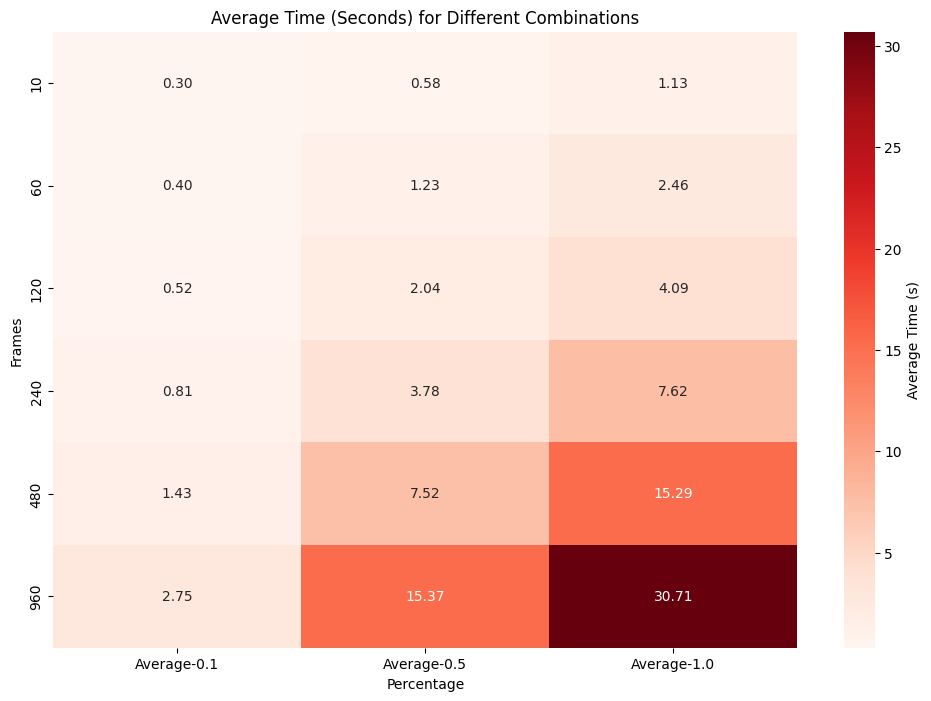

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

avg_data = {key: np.mean(value) for key, value in times.items()}
avg_data

df = pd.DataFrame.from_dict(avg_data, orient='index', columns=['Average'])
df.index = pd.MultiIndex.from_tuples(df.index, names=['Frames', 'Percentage'])

df
df_unstacked = df.unstack(level=-1) 
df_unstacked
plt.figure(figsize=(12, 8))
sns.heatmap(df_unstacked, annot=True, cmap='Reds', fmt=".2f", cbar_kws={'label': 'Average Time (s)'})
plt.title('Average Time (Seconds) for Different Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()

# MAX FPS for uninterrupted animation per combinations

The formula used to get the max FPS, with uninterrupted animation :

$$
Max FPS = \frac{| frames |}{\max(\text{time to generate next matrix})}
$$


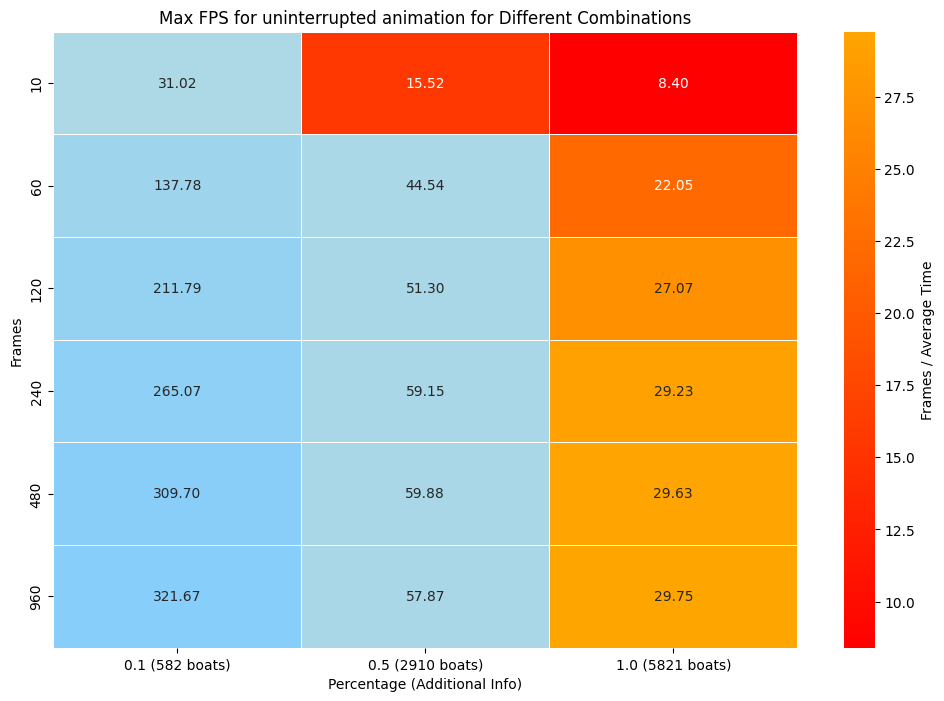

In [3]:

max_data = {key: max(value) for key, value in times.items()}

# Calculate the FPS values using the maximum values
fps_values = {key: key[0] / value for key, value in max_data.items()}
fps_values
# fps_values = {key: key[0] / value for key, value in avg_data.items()}


df_frames_per_value = pd.DataFrame.from_dict(fps_values, orient='index', columns=['Frames_per_Value'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]

# for values below 30
colors_below_30 = ["red", "orange"]
cmap_below_30 = LinearSegmentedColormap.from_list("Below30Colormap", colors_below_30)

# above 30
colors_above_30 = ["#ADD8E6", "#87CEFA"]
cmap_above_30 = LinearSegmentedColormap.from_list("Above30Colormap", colors_above_30)

# Create a mask for values below and above 30
mask_below_30 = df_frames_per_value_unstacked >= 30
mask_above_30 = df_frames_per_value_unstacked < 30

# Plot the heatmap with inverted color gradient for values below 30
plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_below_30, fmt=".2f", cbar_kws={'label': 'Frames / Average Time'}, mask=mask_below_30, linewidths=.5)
light_blue = "#add8e6"  # 
cmap_single_shade = mcolors.ListedColormap([light_blue]) 
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap=cmap_above_30, fmt=".2f", cbar=False, mask=mask_above_30, linewidths=.5)
plt.title('Max FPS for uninterrupted animation for Different Combinations')
plt.xlabel('Percentage (Additional Info)')
plt.ylabel('Frames')
plt.show()

# Memory occupied on disk by 3 matrices (t-1, t, t+1)


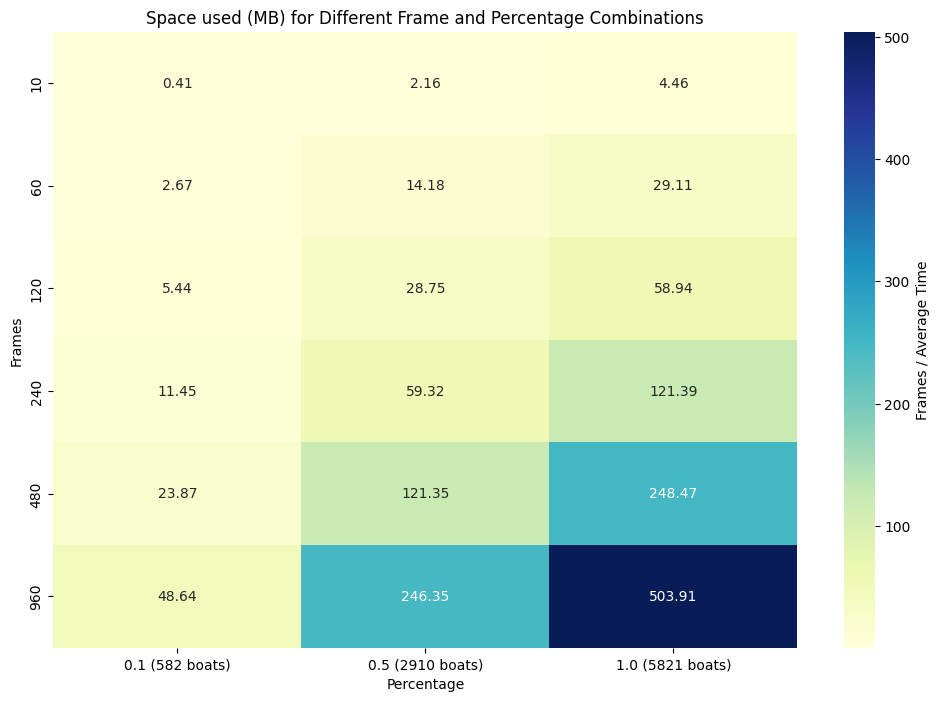

In [4]:

df_frames_per_value = pd.DataFrame.from_dict(memory_used, orient='index', columns=['%'])
df_frames_per_value.index = pd.MultiIndex.from_tuples(df_frames_per_value.index, names=['Frames', 'Percentage'])

df_frames_per_value_unstacked = df_frames_per_value.unstack(level=-1)
df_frames_per_value_unstacked.columns = [f"{col} ({number_of_objects[col]} boats)" for col in df_frames_per_value_unstacked.columns.droplevel(0)]


plt.figure(figsize=(12, 8))
sns.heatmap(df_frames_per_value_unstacked, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'Frames / Average Time'})
plt.title('Space used (MB) for Different Frame and Percentage Combinations')
plt.xlabel('Percentage')
plt.ylabel('Frames')
plt.show()